# Tarea 3: Ajuste de hiperpaŕametros utilizando Tensorflow y Tensorboard

<font size=4>Como hemos comentado en clase, las redes neuronales actualizan los parámetros necesarios, según cada estilo de arquitectura de red especificada, para atacar un problema particular y poder realizar inferencias relacionadas con dicho problema. Ya en el curso hemos visto, y seguiremos viendo, arquitecturas diversas para atacar un gran número de problemas reales. Pero tenemos que tratar otro asunto...

<font size=4>Un problema abierto en Machine Learning es la selección de hiperpaŕametros. Existen diversas técnicas para atacar el problema. Vas a desarrollar un código, para aplicar un **Grid Search** sobre ciertos conjuntos de hiperparámetros, para determinar el mejor algoritmo que resuelva el problema de clasificación para un nuevo dataset que vas a trabajar: Fashion MNIST 

![](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/02/Plot-of-a-Subset-of-Images-from-the-Fashion-MNIST-Dataset-1024x768.png)

<font size=4>Te pedimos, por favor, que tengas a la mano tus notebooks 8, 9 y 10, para resolver la tarea. Te haremos señalizaciones puntuales de dónde consultar cada pregunta. Habrá otras cosas que tendrás que desarrollar por tu cuenta, pero el esfuerzo valdrá la pena. Queremos que este código te permita trabajar tu proyecto final con mucha soltura y con varios experimentos a la vez.

In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [4]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

"rm" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


<font size=4>Importamos las librerías básicas que necesitamos para esta tarea. 

In [79]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import layers
from tensorflow.python.keras.layers import Input, Dense, Activation, Flatten
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.models import Model
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import time

from tensorboard.plugins.hparams import api as hp
np.random.seed(1)

In [6]:
fashion_mnist = tf.keras.datasets.fashion_mnist

<font size=4 color=red>1. Carga los datos de FashionMNIST y separa en los respectivos conjuntos de entrenamiento y test. (HINT: Revisar la parte de preprocesamiento del notebook 10).

In [7]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

<font size=4 color=red>2. Obtener la dimensión de cada conjunto de la celda anterior. (HINT:Revisar la clase 10, en la misma sección de procesamiento del dataset)

In [8]:
print('The shape of x_train is', x_train.shape)
print('The shape of y_train is', y_train.shape)

print('\nThe shape of x_test is', x_test.shape)
print('The shape of y_test is', y_test.shape)

The shape of x_train is (60000, 28, 28)
The shape of y_train is (60000,)

The shape of x_test is (10000, 28, 28)
The shape of y_test is (10000,)


<font size=4 color=red> 3. [Ingresa a este link](https://www.kaggle.com/datasets/zalando-research/fashionmnist) para encontrar la información de lo que significa cada una de las etiquetas. Completa el diccionario que se presenta en la siguiente celda.

In [9]:
dic = {0:"label", 1:"pixel_1", 2:"pixel_2", 3:"pixel_3", 4:"pixel_4", 
       5:"pixel_5", 6:"pixel_6", 7:"pixel_7", 8:"pixel_8", 9:"pixel_9"}

pixel_9 is the object corresponding to the sample 0

 This is its image


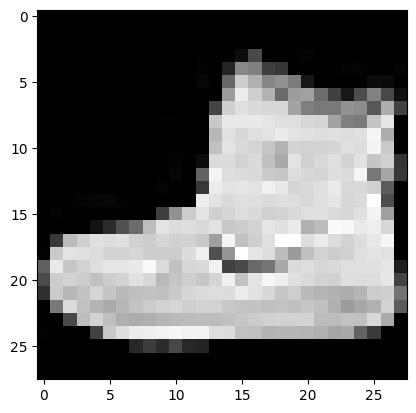

In [10]:
index = 0

plt.imshow(x_train[index],cmap='gray')

print(dic[y_train[index]], "is the object corresponding to the sample", index)
print("\n This is its image")

<font size=4 color=red>4. Analizar si los pixeles de cada imagen están normalizados o no. De no estarlo, hacer la normalización correspondiente. (HINT: Revisar la sección "Analyzing the data extracted from CIFAR-10" del notebook 10)

In [11]:
# El valor de cada pixel esta entre 0 y 255
train_x = x_train/255
test_x = x_test/255

<font size=4 color=yellow>5. Realizar la codificación One-Hot para las etiquetas de este problema. (HINT: Revisar la sección "One Hot Encoding" de los notebooks 8, 9 o 10)

In [16]:
train_y = np.eye(10)[y_train]
test_y = np.eye(10)[y_test]

In [23]:
# Impresion de los primeros 5 valores de y_train y train_y
print(y_train[0:5], "\n", train_y[0:5])

[9 0 0 3 0] 
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


<font size=5 color="blue">

Building the Learning System



<font size=5 color='blue'>

Definition of the neural network architecture

<font size=4>En esta sección vamos a utilizar la arquitectura expuesta en la clase 9, pero vamos a realizar algunas modificaciones para realizar más variaciones al modelo base, así como a otro conjunto de hiperparámetros. A continuación, se expone la manera de realizar estos cambios. No tienes que modificar nada aún.

<font size=4>Primero, se deben inicializar los hiperparámetros, así como sus posibles valores que pueden tomar. Además, vamos a guardar en el Tensorboard el accuracy, de modo que podamos asociar a cada conjunto de hiperparámetros un valor de accuracy, para así comparar y decidir cuál modelo nos puede proporcionar la mejor inferencia. 

In [35]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16, 32]))
HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.1, 0.4]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))
HP_LEARNINGRATE= hp.HParam('learning_rate', hp.Discrete([0.1,0.01,0.001]))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER, HP_LEARNINGRATE],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

<font size=4>Ahora sí, te va a tocar modificar ciertas partes de la arquitectura del código, para realizar la variación de parámetros que se propone en la celda anterior. Te vamos a ayudar con algunos, pero otros tú los vas a tener que modificar. Sigue con cuidado las instrucciones, y obtendrás el resultado esperado.

<font size=4 color=yellow>6. Se te proporciona a continuación la arquitectura de la clase 9. Modifica el código, de tal forma que reciba como parámetros de entrada la probabilidad de aplicar el Dropout, así como el número de neuronas presentes en la segunda capa lineal. Nosotros te ayudamos a cambiar el número de neuronas. Declaramos una variable de entrada llamada **units**, y lo colocamos en donde corresponde. Lo mismo tienes que hacer para la probabilidad del Dropout(es decir,en cada punto donde encuentres p=0, tienes que cambiarlo por una variable de entrada, de modo que podamos barrer otros valores en este punto)

In [42]:
def architecture(input_shape, num_classes, p_drop, units, dropout=True):
    
    # Defining the input as a tensor with shape input_shape. 
    InputLayer = Input(input_shape)
    
    # Flattening the input tensor of dimensions (32, 32, 3) to a tensor of dimensions (3072)
    x = Flatten()(InputLayer)
    if dropout == True:
        x = Dropout(p_drop)(x)
    
    # Defining the first hidden layer with 50 nodes and sigmoid as activation function
    x = Dense(50, kernel_initializer='random_uniform', bias_initializer='zeros', name='hl_1')(x)
    x = Activation('sigmoid')(x)
    if dropout == True:
        x = Dropout(p_drop)(x)

    x = Dense(units, kernel_initializer='random_uniform', bias_initializer='zeros', name='hl_2')(x)
    x = Activation('sigmoid')(x)
    if dropout == True:
        x = Dropout(p_drop)(x)
    
    
    # For the output layer we use the activation function 'softmax')
    x = Dense(num_classes, kernel_initializer='random_uniform', bias_initializer='zeros')(x)
    OutputLayer = Activation('softmax', name='output-layer')(x)
    
    # This creates the Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = InputLayer, outputs = OutputLayer, name='Cifar10Model')

    return model

<font size=4 color=yellow>7. Vamos a definir una función llamada train_test_model, en donde vamos a definir todos los pasos importantes para realizar el entrenamiento. La única línea de código que vas a modificar, es la línea 17 de la siguiente celda. Vamos a loggear al Tensorboard el accuracy sobre el conjunto de evaluacion. Aplica el método **evaluate** sobre los conjuntos de prueba. (HINT: Revisa los notebooks 8,9 y 10 para que veas la manera de hacer esto)

In [43]:
one_image = (28, 28, 1)
num_classes=10


def train_test_model(hparams):

    model=architecture(input_shape=one_image, num_classes=num_classes, 
                       p_drop=hparams[HP_DROPOUT], units=hparams[HP_NUM_UNITS])
    model.compile(
          optimizer=hparams[HP_OPTIMIZER],
          loss='categorical_crossentropy',
          metrics=['accuracy']
      )
    model.optimizer.learning_rate=hparams[HP_LEARNINGRATE]
    model.fit(x_train, train_y, epochs = 1, batch_size = 32, \
                                validation_split = 0.1, shuffle=True, verbose=0) # Run with 1 epoch to speed things up for demo purposes
    evaluations = model.evaluate(x = test_x, y = test_y)
    accuracy = evaluations[1]
    
    return accuracy

<font size=4> En la siguiente función, vamos a compactar todo lo que queremos pasarle a nuestro Tensorboard, incluyendo los hiperparámetros y una ruta donde se guardarán todos los resultados. No tienes que modificar nada

In [44]:
def training(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        accuracy = train_test_model(hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

<font size=4>Finalmente, en la siguiente celda realizamos los entrenamientos sobre todas las posibilidades de hiperparámetros a probar. Nótese que solo correremos 5 épocas. Queremos encontrar un modelo tal que nos ofrezca la mejor solución al problema de clasificación. Solo ejecuta la siguiente celda.

In [45]:
from collections import OrderedDict, namedtuple
from itertools import product
session_num = 0

class RunBuilder():
    @staticmethod
    def get_runs(params):
        Run=namedtuple('Run', params.keys())

        runs=[]

        for v in product(*params.values()):
            runs.append(Run(*v))

        return runs
    
params=OrderedDict(
        num_units=[num_units for num_units in HP_NUM_UNITS.domain.values],
        p_drop=[dropout_rate for dropout_rate in (HP_DROPOUT.domain.values)],
        optim=[optimizer for optimizer in HP_OPTIMIZER.domain.values],
        lr=[lr for lr in HP_LEARNINGRATE.domain.values],
    )

for run in RunBuilder().get_runs(params):
    hparams = {
          HP_NUM_UNITS: run.num_units,
          HP_DROPOUT: run.p_drop,
          HP_OPTIMIZER: run.optim,
          HP_LEARNINGRATE: run.lr
      }
    run_name = "run-%d" % session_num
    print('--- Starting trial: %s' % run_name)
    print({h.name: hparams[h] for h in hparams})
    training('logs/hparam_tuning/' + run_name, hparams)
    session_num += 1


--- Starting trial: run-0
{'num_units': 16, 'dropout': 0.1, 'optimizer': 'adam', 'learning_rate': 0.001}
313/313 [==============================] - 1s 1ms/step - loss: 1.2259 - accuracy: 0.5372
--- Starting trial: run-1
{'num_units': 16, 'dropout': 0.1, 'optimizer': 'adam', 'learning_rate': 0.01}
313/313 [==============================] - 1s 990us/step - loss: 1.6562 - accuracy: 0.2939
--- Starting trial: run-2
{'num_units': 16, 'dropout': 0.1, 'optimizer': 'adam', 'learning_rate': 0.1}
313/313 [==============================] - 1s 1ms/step - loss: 2.3132 - accuracy: 0.1000
--- Starting trial: run-3
{'num_units': 16, 'dropout': 0.1, 'optimizer': 'sgd', 'learning_rate': 0.001}
313/313 [==============================] - 1s 1ms/step - loss: 2.3028 - accuracy: 0.1000
--- Starting trial: run-4
{'num_units': 16, 'dropout': 0.1, 'optimizer': 'sgd', 'learning_rate': 0.01}
313/313 [==============================] - 1s 1ms/step - loss: 2.2914 - accuracy: 0.1034
--- Starting trial: run-5
{'num_un

## Visualización de los resultados en Tensorboard

The HParams dashboard can now be opened. Start TensorBoard and click on "HParams" at the top.

In [46]:
%tensorboard --logdir logs/hparam_tuning

<font size=4>En las pestañas del lado superior izquierdo, hay una llamada HPARAMS. Ingresa en esa pestaña. También en las pestañas de la parte superior de esta pestaña, encontrarás una opción llamada Parallel Coordinates View. En esa opción podrás ver de manera interactiva las diferentes opciones de variación, y su respectivo valor de precisión en Inferencia.

<font size=4 color=yellow> 8. En el menú interactivo del lado izquierdo, hasta abajo viene una opción que dice: "Download data as CSV". Descarga estos datos y anexalos al momento de subir tu notebook al Classroom. Nota que a pesar de que se tiene una semilla para reproducibilidad, no se obtienen los mismo resultados una vez se ejecuten nuevamente los resultados. Por ello, si alguien te pasa su CSV, nos daremos inmediatamente cuenta, porque no es posible que salgan dos juegos de datos iguales :)

Estoy usando VSCODE pero nunca tuve la opción de hacer lo del CSV. Si se puede podríamos hacerlo juntos para poder checar donde se puede acceder a esa opcion sería increíble. Gracias

<font size=4 color=yellow>9. De los tres mejores modelos que obtuviste en esta prueba básica, realiza un entrenamiento completo de 30 épocas con alguno de ellos, como lo realizamos en la clase. A continuación te enumeramos los pasos a seguir para este punto, pero recuerda checar con cuidado los parámetros que debes modificar en cada paso, de modo que pongas los hiperparámetros óptimos que te permitieron obtener el mejor resultado de accuracy en el conjunto test. 

In [47]:
def architecture(input_shape, num_classes, dropout=True):
    
    # Defining the input as a tensor with shape input_shape. 
    InputLayer = Input(input_shape)
    
    # Flattening the input tensor of dimensions (32, 32, 3) to a tensor of dimensions (3072)
    x = Flatten()(InputLayer)
    if dropout == True:
        x = Dropout(0.1)(x)
    
    # Defining the first hidden layer with 50 nodes and sigmoid as activation function
    x = Dense(50, kernel_initializer='random_uniform', bias_initializer='zeros', name='hl_1')(x)
    x = Activation('sigmoid')(x)
    if dropout == True:
        x = Dropout(0.1)(x)

    # Defining the second hidden layer with 50 nodes and sigmoid as activation function
    x = Dense(32, kernel_initializer='random_uniform', bias_initializer='zeros', name='hl_2')(x)
    x = Activation('sigmoid')(x)
    if dropout == True:
        x = Dropout(0.1)(x)
    
    
    # For the output layer we use the activation function 'softmax')
    x = Dense(num_classes, kernel_initializer='random_uniform', bias_initializer='zeros')(x)
    OutputLayer = Activation('softmax', name='output-layer')(x)
    
    # This creates the Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = InputLayer, outputs = OutputLayer, name='Cifar10Model')

    return model

<font size=4 color=red>En la celda anterior, recuerda poner la probabilidad de Dropout y el número de neuronas de salida en la segunda capa lineal que mejor funcionaron para ti

In [48]:
best_model=architecture((28,28,1), 10)

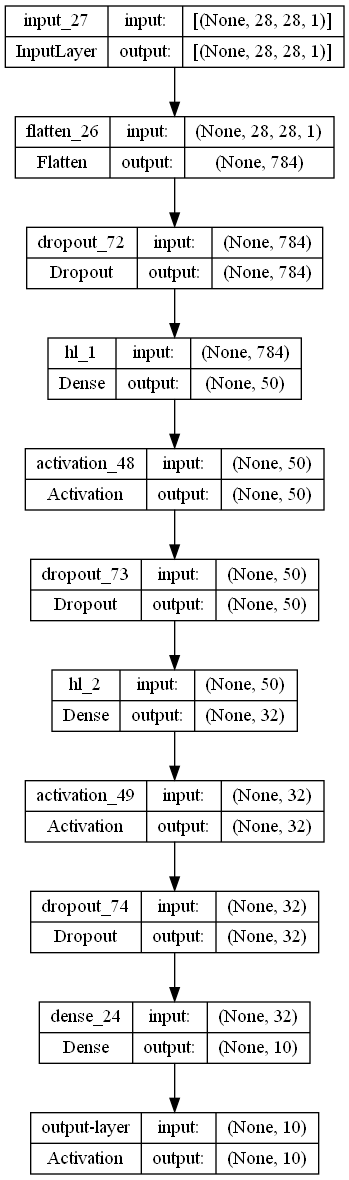

In [49]:
plot_model(best_model, to_file='best_model.png', show_shapes=True, rankdir='TB', show_layer_names=True)

In [50]:
best_model.summary()

Model: "Cifar10Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 784)               0         
_________________________________________________________________
dropout_72 (Dropout)         (None, 784)               0         
_________________________________________________________________
hl_1 (Dense)                 (None, 50)                39250     
_________________________________________________________________
activation_48 (Activation)   (None, 50)                0         
_________________________________________________________________
dropout_73 (Dropout)         (None, 50)                0         
_________________________________________________________________
hl_2 (Dense)                 (None, 32)               

In [53]:
learning_rate = 0.01

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

<font size=4 color=red>Ahora, también cambia en la anterior celda el learning rate y el optimizador que mejor funcionaron para ti

In [54]:
loss_function = 'categorical_crossentropy'
metric_function = 'accuracy'

In [58]:
best_model.compile(optimizer = "adam", loss = loss_function, metrics = [metric_function])

In [60]:
#10 % of the training data will be used to validate the training
start_time = time.time()

validation_portion = 0.1
batch_size=128
num_epochs = 30

tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir="logs/best_model", histogram_freq=1)

history = best_model.fit(x=x_train, y=train_y, epochs=num_epochs, batch_size=batch_size, \
                            validation_split=validation_portion, shuffle=True,
                            callbacks=[tensorboard_callback], verbose=1)

end_time = time.time()
print("Time for training: {:10.4f}s".format(end_time - start_time))

Epoch 1/30
422/422 [==============================] - 2s 5ms/step - loss: 0.7642 - accuracy: 0.7037 - val_loss: 0.6802 - val_accuracy: 0.7337
Epoch 2/30
422/422 [==============================] - 2s 4ms/step - loss: 0.7416 - accuracy: 0.7136 - val_loss: 0.6645 - val_accuracy: 0.7447
Epoch 3/30
422/422 [==============================] - 2s 4ms/step - loss: 0.7389 - accuracy: 0.7228 - val_loss: 0.6445 - val_accuracy: 0.7593
Epoch 4/30
422/422 [==============================] - 2s 4ms/step - loss: 0.7485 - accuracy: 0.7152 - val_loss: 0.6527 - val_accuracy: 0.7445
Epoch 5/30
422/422 [==============================] - 1s 3ms/step - loss: 0.7214 - accuracy: 0.7311 - val_loss: 0.6307 - val_accuracy: 0.7622
Epoch 6/30
422/422 [==============================] - 2s 4ms/step - loss: 0.7215 - accuracy: 0.7255 - val_loss: 0.6460 - val_accuracy: 0.7368
Epoch 7/30
422/422 [==============================] - 2s 4ms/step - loss: 0.7051 - accuracy: 0.7276 - val_loss: 0.6117 - val_accuracy: 0.7723
Epoch 

<font size=4 color=red> 10. Realiza las gráficas de costo y accuracy para cada conjunto, entrenamiento y validación. Explica si tu modelo presenta overfitting, underfitting o si es un buen modelo. Argumenta lo mejor que puedas tu respuesta. (HINT: Revisa la clase 10 para realizar estas gráficas. Añade un título descriptivo de tu experimento a cada gráfica, como se hace en específico en esta notebook.)

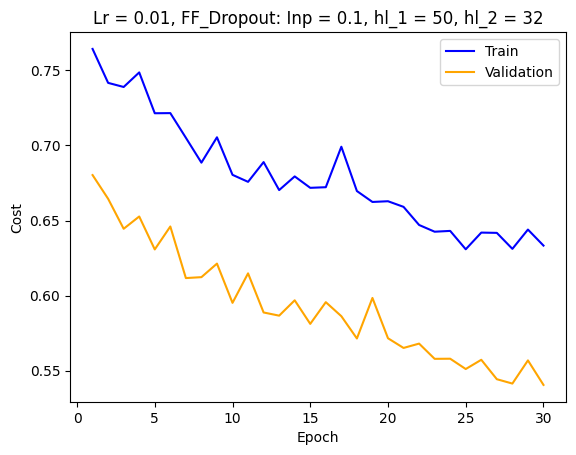

In [83]:
num_epochs = range(1,31)
plt.plot(num_epochs,history.history['loss'], color='blue')
plt.plot(num_epochs,history.history['val_loss'], color='orange')
plt.title('Lr = 0.01, FF_Dropout: Inp = 0.1, hl_1 = 50, hl_2 = 32')
plt.ylabel('Cost')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

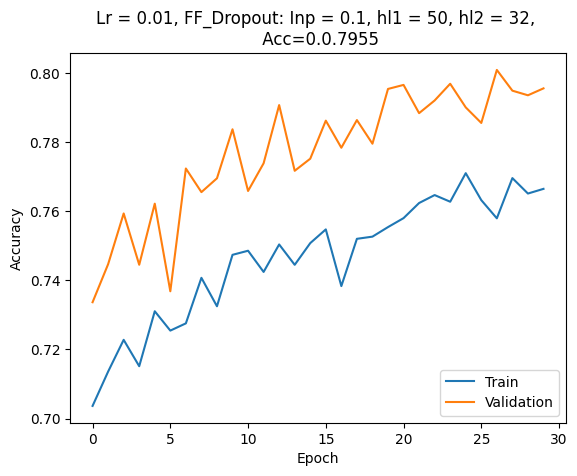

In [84]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Lr = 0.01, FF_Dropout: Inp = 0.1, hl1 = 50, hl2 = 32, \n Acc=0.0.7955')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

En general, se puede apreciar que es un buen modelo puesto que todavía no se puede apreciar que exista un sobreajuste ya que la línea de nuestra gráfica de datos de validación del accuracy así como también el de entrenamiento van en tendencia hacia arriba. Puede que con algunas variaciones pero en general con una tendencia a la alza.

Si corrieramos el modelo durante más epocas puede que siga mejorando o bien ya exista un sobreajuste. Para ello lo haremos en la siguiente celda de nuestro punto extra.

# Puntos Extras!!!

<font size=5 color=blue> E1. Modifica los valores que se proponen en la celda 14, donde definimos los hiperparámetros a varias, y realiza la variación de parámetros. Si encuentras un modelo que obtenga más del 90% de accuracy en test, realiza un entrenamiento completo, y haz el análisis sobre el under-overfitting. Anexa en tu tarea para obtener el punto extra el CSV del Tensorboard, así como el modelo. (+1)

In [85]:
start_time = time.time()

validation_portion = 0.1
batch_size=128
num_epochs = 30

tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir="logs/best_model", histogram_freq=1)

history = best_model.fit(x=x_train, y=train_y, epochs=num_epochs, batch_size=batch_size, \
                            validation_split=validation_portion, shuffle=True,
                            callbacks=[tensorboard_callback], verbose=1)

end_time = time.time()
print("Time for training: {:10.4f}s".format(end_time - start_time))

Epoch 1/100
422/422 [==============================] - 2s 5ms/step - loss: 0.6191 - accuracy: 0.7730 - val_loss: 0.5435 - val_accuracy: 0.8052
Epoch 2/100
422/422 [==============================] - 2s 4ms/step - loss: 0.6266 - accuracy: 0.7683 - val_loss: 0.5367 - val_accuracy: 0.7923
Epoch 3/100
422/422 [==============================] - 2s 4ms/step - loss: 0.6238 - accuracy: 0.7695 - val_loss: 0.5597 - val_accuracy: 0.7873
Epoch 4/100
422/422 [==============================] - 2s 4ms/step - loss: 0.6306 - accuracy: 0.7651 - val_loss: 0.5675 - val_accuracy: 0.7970
Epoch 5/100
422/422 [==============================] - 2s 4ms/step - loss: 0.6431 - accuracy: 0.7673 - val_loss: 0.5504 - val_accuracy: 0.7995
Epoch 6/100
422/422 [==============================] - 2s 4ms/step - loss: 0.6486 - accuracy: 0.7662 - val_loss: 0.5444 - val_accuracy: 0.7958
Epoch 7/100
422/422 [==============================] - 2s 4ms/step - loss: 0.6385 - accuracy: 0.7655 - val_loss: 0.5469 - val_accuracy: 0.8028

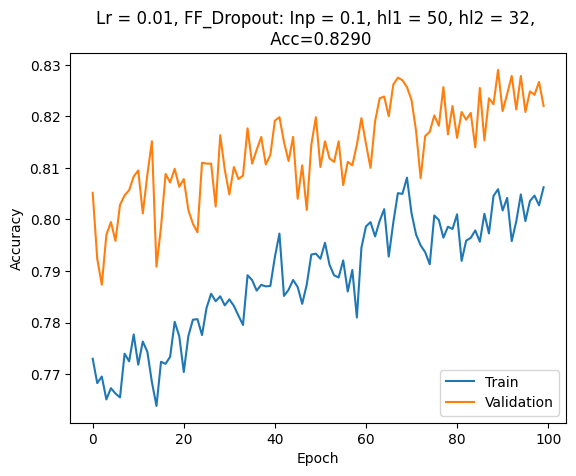

In [87]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Lr = 0.01, FF_Dropout: Inp = 0.1, hl1 = 50, hl2 = 32, \n Acc=0.8290')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

Se obtiene un accuracy del 82.9 %